
# Experiment for a repeating and integration 

In [8]:
#import e3dlib_upgrade.main

In [9]:
import math
from datetime import datetime, timedelta
from fractions import Fraction
from e3d.commanding import (
    Experiment,
    Frequency,
    BeamPointing,
    Timing,
    Code,
    Polarization,
    Polarity,
    Decimation,
    RangeExtent,
    __version__
)
print(__version__)

2.22.0


In [10]:
rx_freq = Frequency(229.125, "MHz")  #229.125 for calibration generator
# for some reason, the transmit and receive frequency are offset by 200 kHz. 
# is this exact? Why is there an offset? Could this offset be hidden. If
# you request 233 MHz, one would expect the system to be tuned to 233 MHz. 
tx_freq = Frequency(229.125-0.2, "MHz")
# 104 MHz sample-rate 104 decimate => 1 MHz sample-rate
decimation = Decimation(104)
sample_factor=1
#decimation = Decimation(104)


# 7 module receiver
# could this be e.g., pet?
site_rx = "pet"
# 1 module transmitter
site_tx = "pet"

# beam pointing
radar_az=0
radar_el=70

bp = BeamPointing(az=radar_az, el=radar_el, degrees=True)


# this is an interval of time used by this experiment

# define time slice
# this is a 100 us pulse? "pulse_n_0.0001"
# "pulse_n_3e-05" is a <10 us pulse
n_pulses=200
ipp=1000
nbeams = 1
frames = 20
nrep=1

# create new experiment
expr = Experiment(name="test_integration")
# add an instruction to the experiment
# what should radar do
ins = expr.add_instruction()
# repeat a cycle nrep times. "B" is an id that refers to a timing
cyc = ins.add_cycle().iterate(Timing("B", nrep))  

nsamples=n_pulses*ipp*sample_factor
# 104
code_name="barker13_4u_200kHz"   #barker13_4u_200kHz
#code_name="pulse_n_3e-05"
decode_barker=True

# Repeat pulses using different widebeams, will do loadbalacing as data goes to different pipeline.
for frame_idx in range(frames):
    for ibeam in range(nbeams):    
        ts = cyc.add_timeslice(timing=Timing("A"))
        for pulse_idx in range(n_pulses):
        #    print(Timing(timedelta(microseconds=pulse_idx*ipp+pulse_idx*0.0 + 20), ref=ts))
            tx = ts.add_transmission(
                site=site_tx, # what is the transmitter
                # timing relative to start of slice
                timing=Timing(timedelta(microseconds=pulse_idx*ipp+pulse_idx*0.435 + 20), ref=ts), 
                beam_pointing=bp,
                code=Code(code_name, 0),   # reference to library of pulses      
                # phase difference between X and Y linear polarizations
                polarization=Polarization(90.),   
                carrier_frequency=tx_freq,
                rx_end=Timing(timedelta(microseconds=pulse_idx*ipp+ipp-100), after=ts)
            )
    
        # az and el offset from wide beam boresight direction
        narrow_beam_pointings = [BeamPointing.from_offset(az=0, el=0, degrees=True)]
        
        # receive definition
        # for each receiver wide beam (up to 10 possible)
        
            # each rx antenna polarization
        for polarity in Polarity.A:
            rx = ts.add_reception(
                site=site_rx,
                timing=Timing(timedelta(microseconds=0), ref=ts),
                polarity=polarity,
                wide_beam_index=ibeam,
                wide_beam_pointing=bp,
                nsamples=nsamples,
                center_frequency=rx_freq,
                decimation=decimation
            )
            # second stage beamformer
            ssbf = ts.add_ssbf(
                site=site_rx,
                input=rx.output,
                narrow_beam_pointings=narrow_beam_pointings
            )
            # 
            ssbf.output.note.update(
                az=bp.az_deg,
                el=bp.el_deg,
            )
        # we add one more time slice to indicate that radar
        # control ends.
        cyc.add_timeslice(Timing("A"))  # sentinel
        
        # add a definition of computation pipeline
        comp = ins.add_computation()
        
        # hard target filter, copy this process and insert it at the output of
        # the ssbf like this:
        for ssbf_output in cyc.output.unused:
            hter = comp.add_hter(site=site_rx, input=ssbf_output, nout=nrep)
            hter.output.note.update(**ssbf_output.note)
        
        # get tuples
        for (beam, pol, idx), outputs in comp.output.unused.groupby(("beam", "polarity", "index")):
            az = [output.note["az"] for output in outputs]
            el = [output.note["el"] for output in outputs]
        
            comp.add_export(
                site=site_rx,
                input=hter.output,
                parameters={
                    "frame_idx": frame_idx,
                    "nsamples": nsamples,
                    "polarity": pol,
                    "az": az,
                    "el": el,
                    "ib": beam,
                    "idx": idx,
                    "type": "passthrough",
                })



/tmp/ipykernel_258092/792085101.py:61: UserWarning: Unknown code name: 'barker13_4u_200kHz'.
  code=Code(code_name, 0),   # reference to library of pulses
/tmp/ipykernel_258092/792085101.py:65: UserWarning: `after` is deprecated, use ref instead.
  rx_end=Timing(timedelta(microseconds=pulse_idx*ipp+ipp-100), after=ts)


In [11]:
# note entirely sure what A and B is

# add all the defined computations
op = expr.add_operation(ins)

slice_length = n_pulses*ipp
expr.resolve_timing(
    A=timedelta(seconds=0.21),
    B=timedelta(seconds=20)
    )
# send experiment to database 
expr.commit()


    

Experiment({'created_at': '2024-05-29T13:57:52.963159', 'created_by': '07731657-7449-43e2-81b6-405a8971399b', 'name': 'test_integration', 'status': 'pending', 'uuid': '4550f0c5-ce7a-4fe7-af2d-4395413ef2d2'})

In [12]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 6))
#ins.plot_pointing()
#plt.tight_layout()

#plt.figure(figsize=(10, 6))
#ins.plot_timing()
#plt.tight_layout()

In [13]:
#for i in range(10):
# request radar to run the experiment after 10 seconds
op.set_start_time(after=timedelta(seconds=40))
op.commit()


Operation(idx=0) @ Experiment(id='4550f0c5-ce7a-4fe7-af2d-4395413ef2d2') [20 products]

  0%|          | 0/20 [00:00<?, ? files/s, ETA=2024-05-29 13:58:45]

/e3d/data/2024/May/29/115028849.bin
WBeam idx 0 (200, 1000)


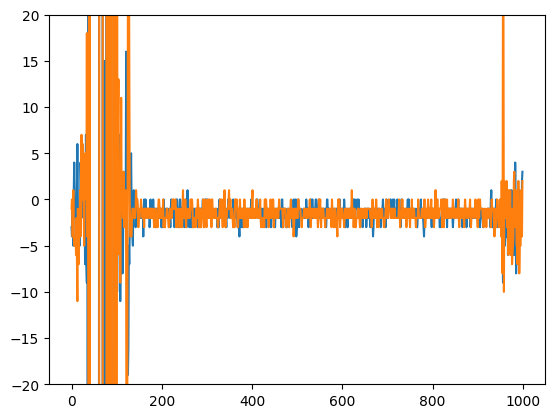

(200, 1000) (-2+0j) (-1.5023-1.5002j) dc offset -1,-1 noise std 0.71


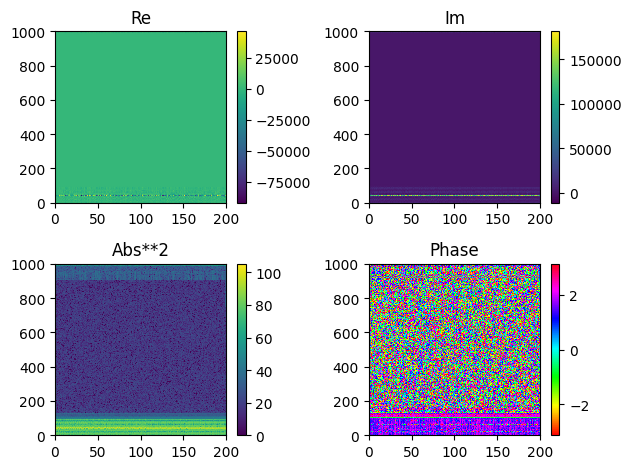

/e3d/data/2024/May/29/115028852.bin
WBeam idx 0 (200, 1000)


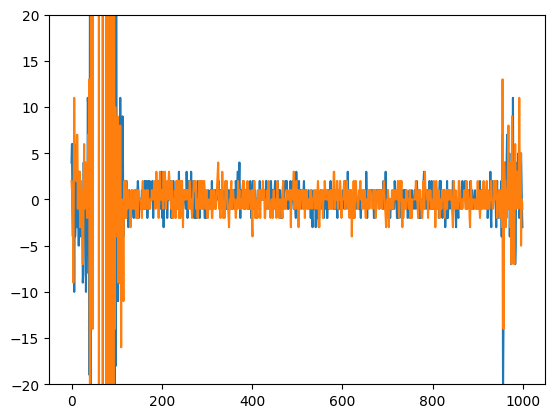

(200, 1000) (-2+1j) (-1.4989083-1.4974834j) dc offset -1,-1 noise std 0.71


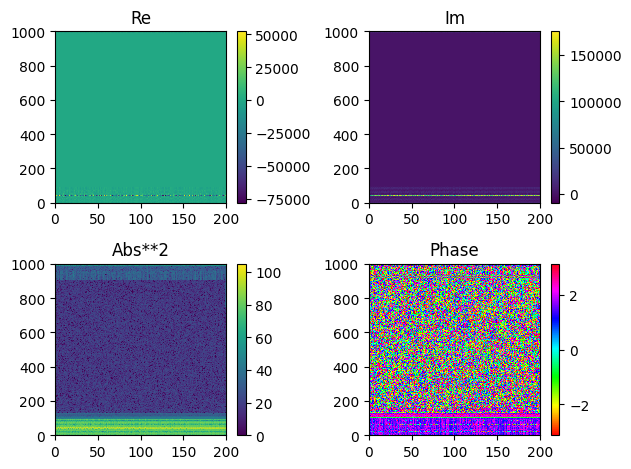

/e3d/data/2024/May/29/115028856.bin
WBeam idx 0 (200, 1000)


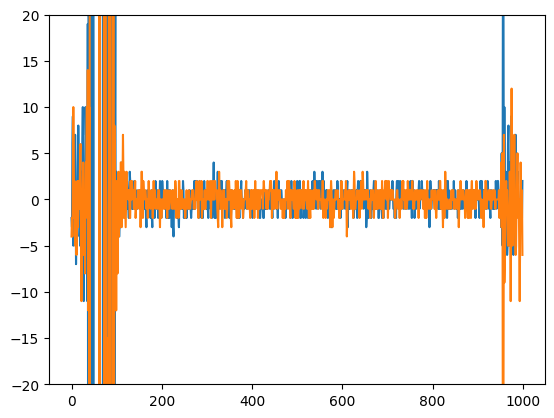

(200, 1000) (-2+0j) (-1.4988667-1.4970417j) dc offset -1,-1 noise std 0.71


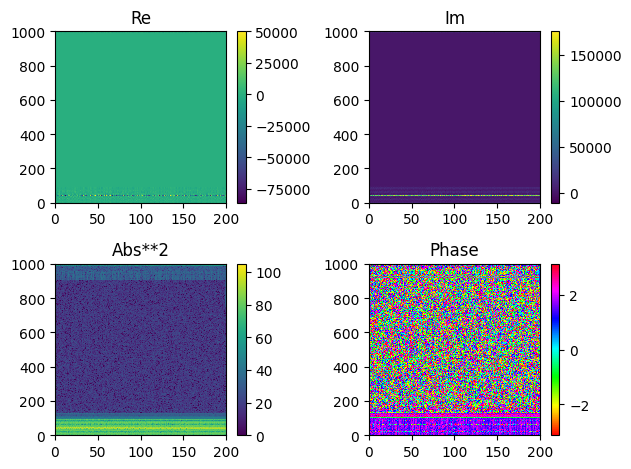

/e3d/data/2024/May/29/115028861.bin
WBeam idx 0 (200, 1000)


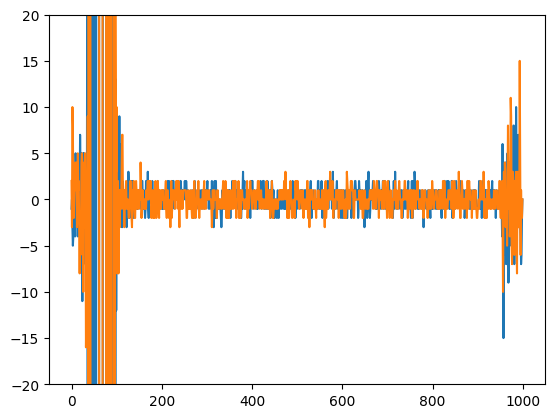

(200, 1000) (-2+1j) (-1.5008416-1.4967083j) dc offset -1,-1 noise std 0.71


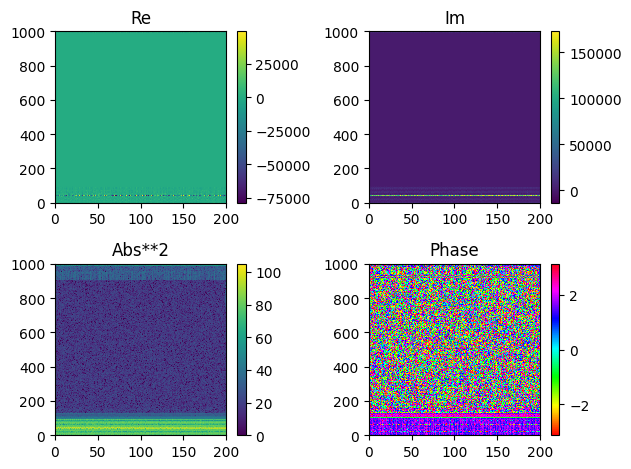

/e3d/data/2024/May/29/115028867.bin
WBeam idx 0 (200, 1000)


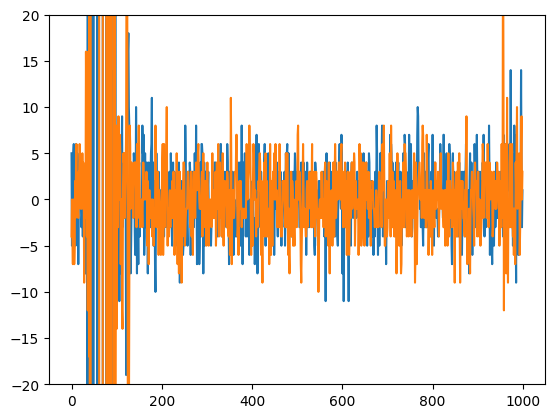

(200, 1000) (-2+3j) (-1.522225-1.496175j) dc offset -1,-1 noise std 2.53


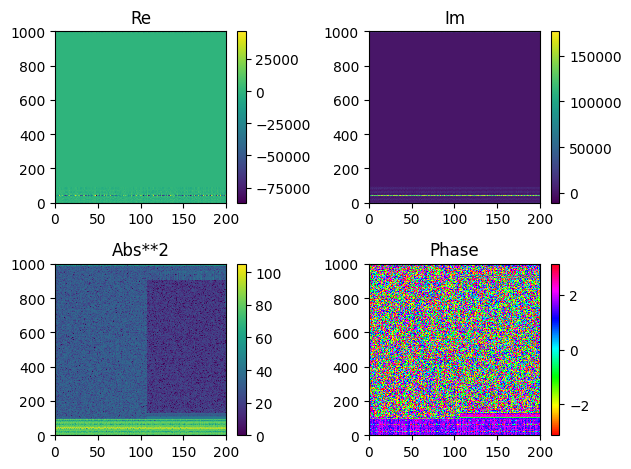

/e3d/data/2024/May/29/115028874.bin
WBeam idx 0 (200, 1000)


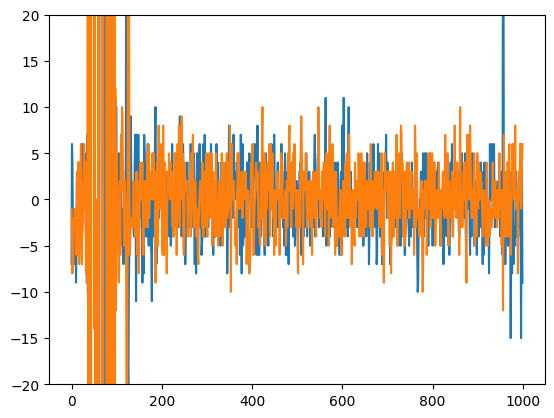

(200, 1000) (-2+1j) (-1.498575-1.499675j) dc offset -1,-1 noise std 0.71


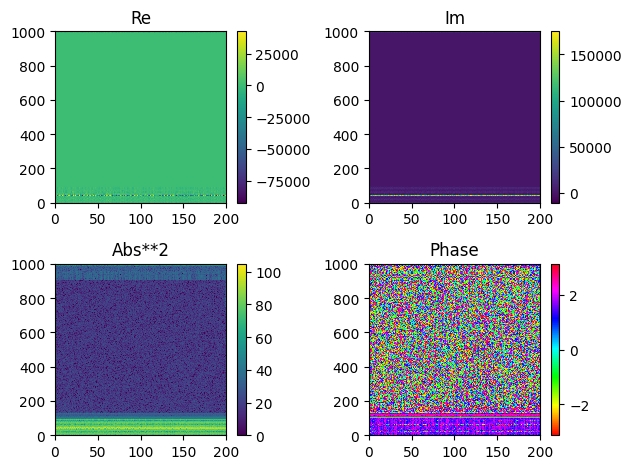

/e3d/data/2024/May/29/115028882.bin
WBeam idx 0 (200, 1000)


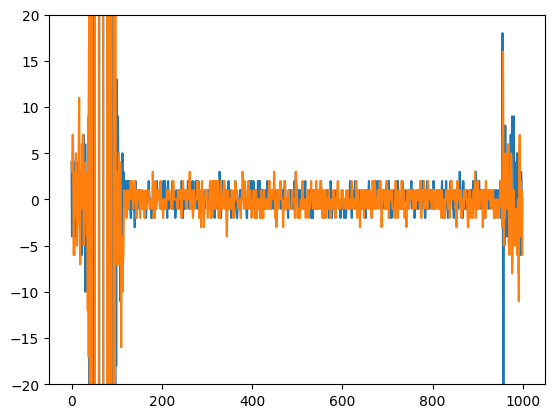

(200, 1000) (-2+0j) (-1.500175-1.5009834j) dc offset -1,-1 noise std 0.71


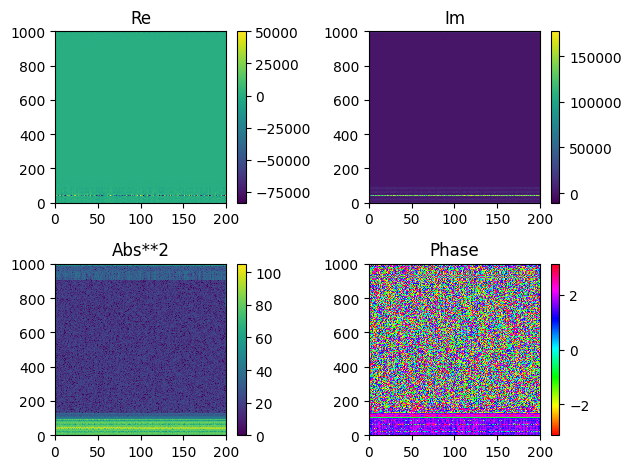

/e3d/data/2024/May/29/115028891.bin
WBeam idx 0 (200, 1000)


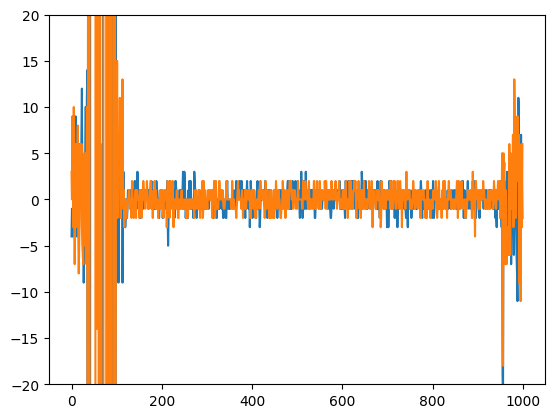

(200, 1000) (-2+0j) (-1.5022167-1.50205j) dc offset -1,-1 noise std 0.71


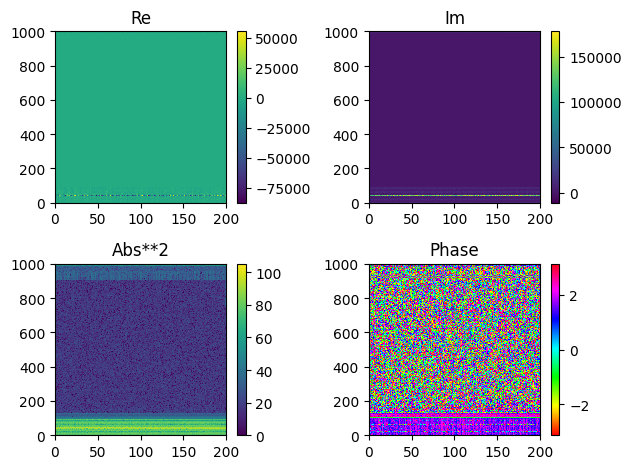

/e3d/data/2024/May/29/115028901.bin
WBeam idx 0 (200, 1000)


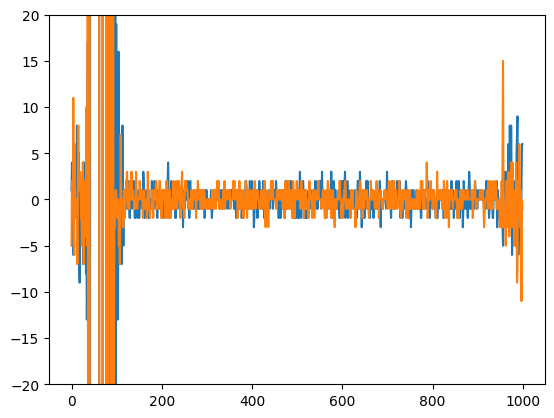

(200, 1000) (-2+0j) (-1.5012833-1.495225j) dc offset -1,-1 noise std 0.71


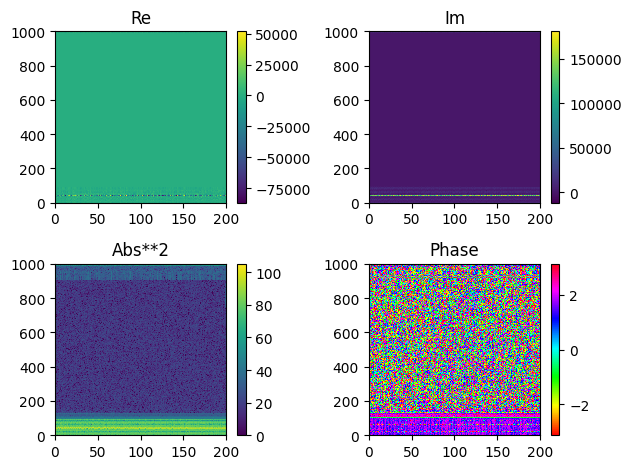

/e3d/data/2024/May/29/115028912.bin
WBeam idx 0 (200, 1000)


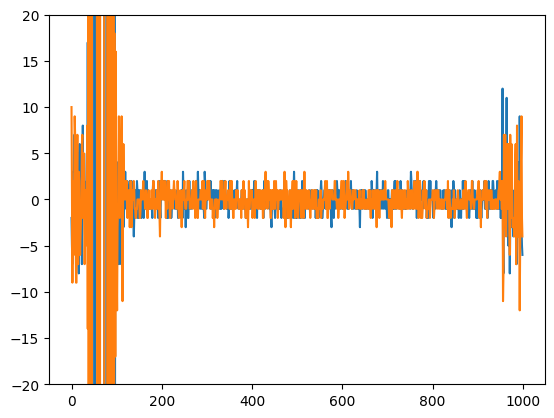

(200, 1000) (-2+1j) (-1.4979583-1.5006833j) dc offset -1,-1 noise std 0.71


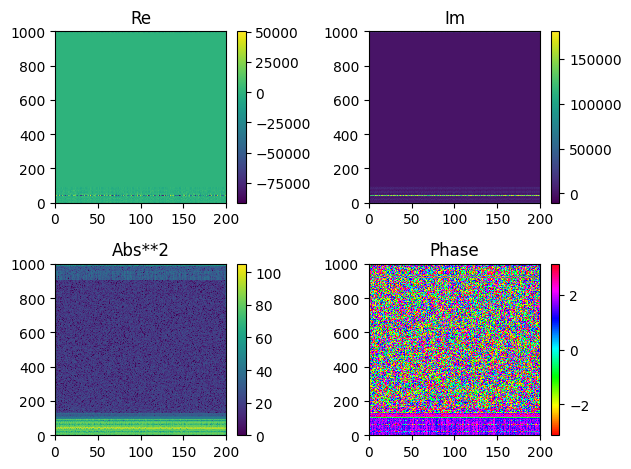

/e3d/data/2024/May/29/115028924.bin
WBeam idx 0 (200, 1000)


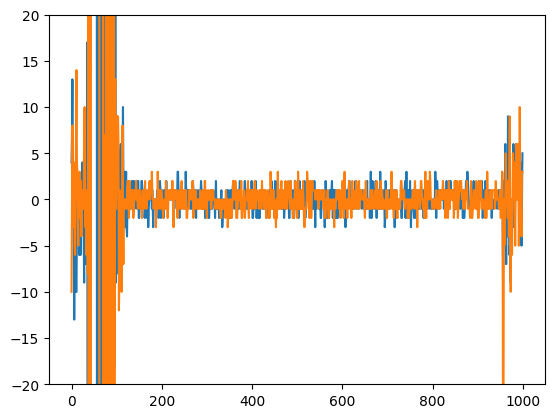

(200, 1000) (-2+1j) (-1.5010583-1.4996583j) dc offset -1,-1 noise std 0.71


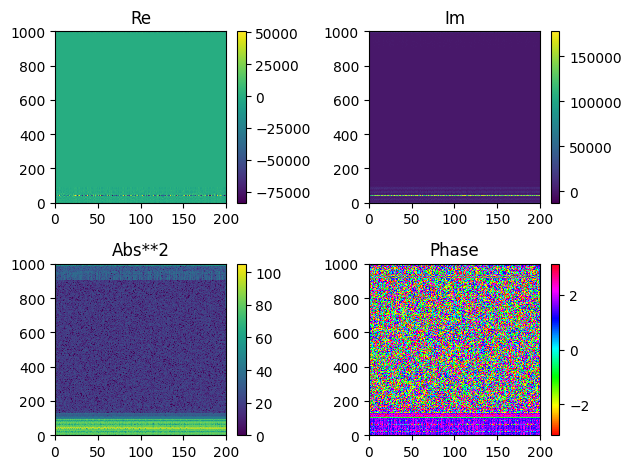

/e3d/data/2024/May/29/115028937.bin
WBeam idx 0 (200, 1000)


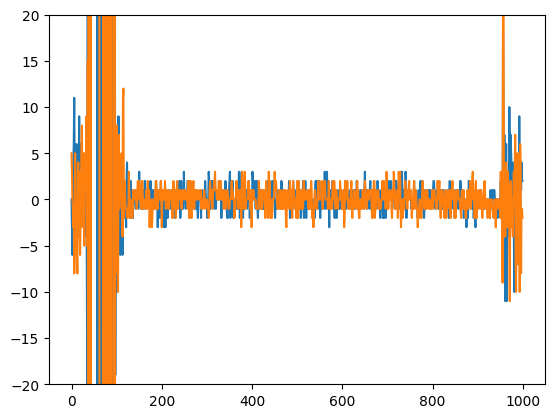

(200, 1000) (-2+1j) (-1.49655-1.49995j) dc offset -1,-1 noise std 0.71


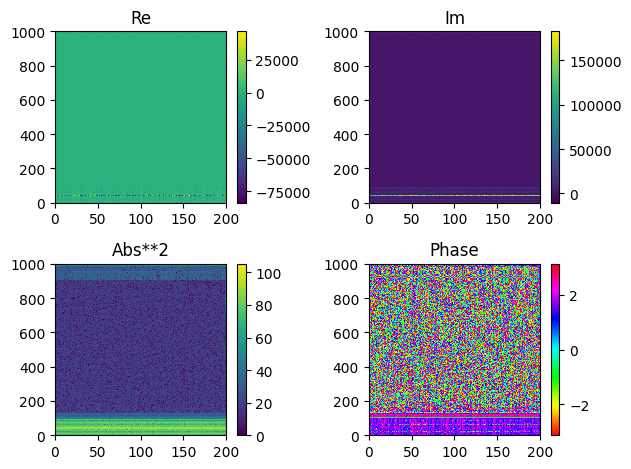

/e3d/data/2024/May/29/115028951.bin
WBeam idx 0 (200, 1000)


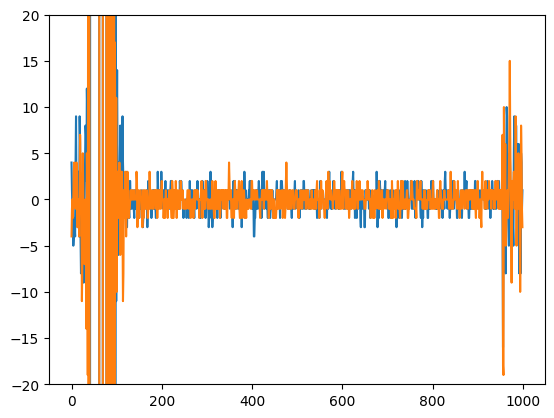

(200, 1000) (-2+1j) (-1.4906-1.500625j) dc offset -1,-1 noise std 0.71


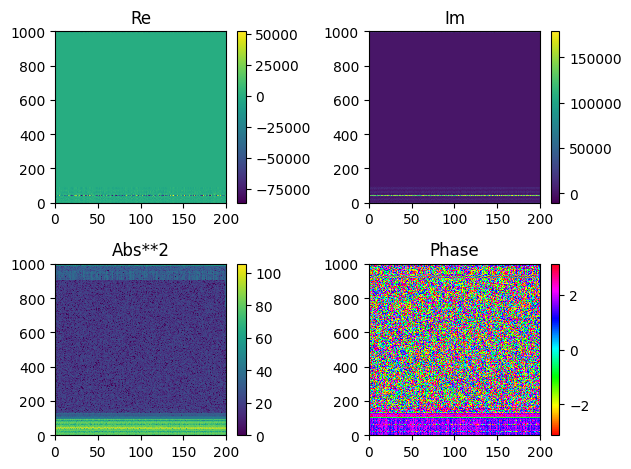

/e3d/data/2024/May/29/115028966.bin
WBeam idx 0 (200, 1000)


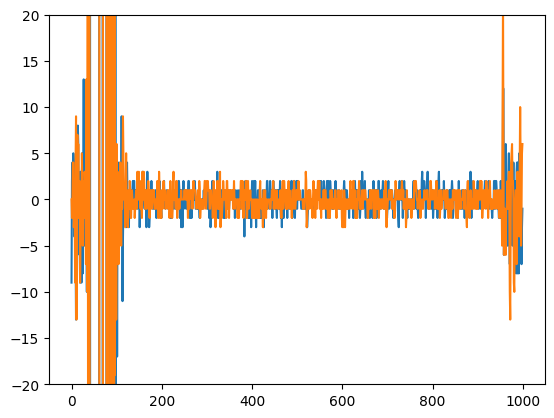

(200, 1000) (-2+1j) (-1.4966834-1.5042917j) dc offset -1,-1 noise std 0.71


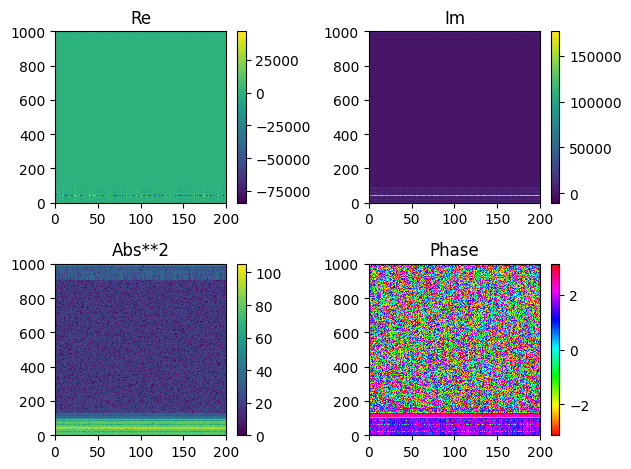

/e3d/data/2024/May/29/115028982.bin
WBeam idx 0 (200, 1000)


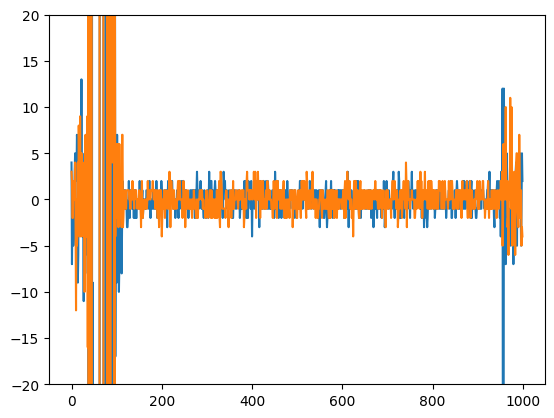

(200, 1000) (-2+0j) (-1.4989-1.5017333j) dc offset -1,-1 noise std 0.71


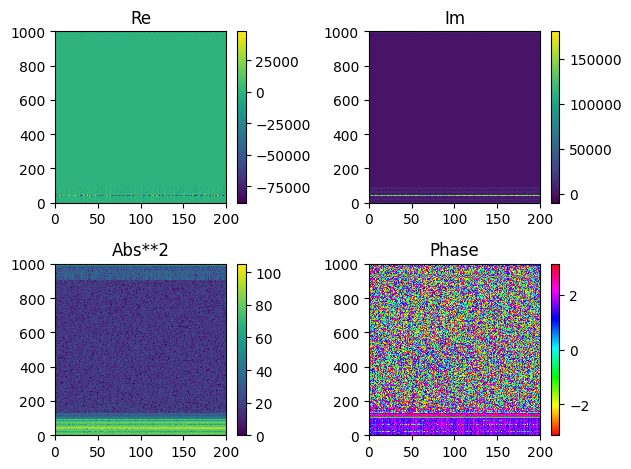

/e3d/data/2024/May/29/115028999.bin
WBeam idx 0 (200, 1000)


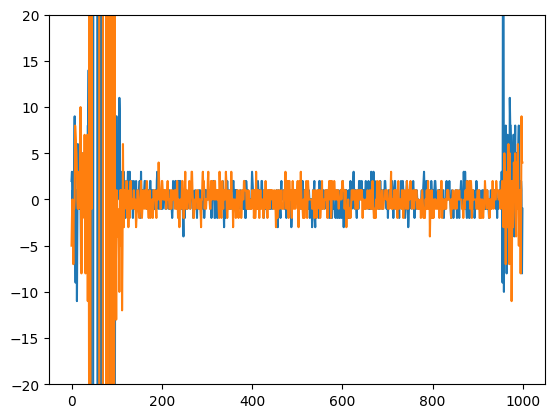

(200, 1000) (-2+1j) (-1.4989834-1.4992167j) dc offset -1,-1 noise std 0.71


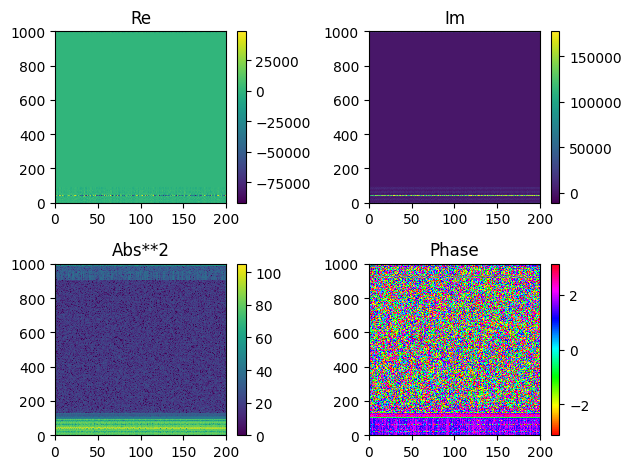

/e3d/data/2024/May/29/115029017.bin
WBeam idx 0 (200, 1000)


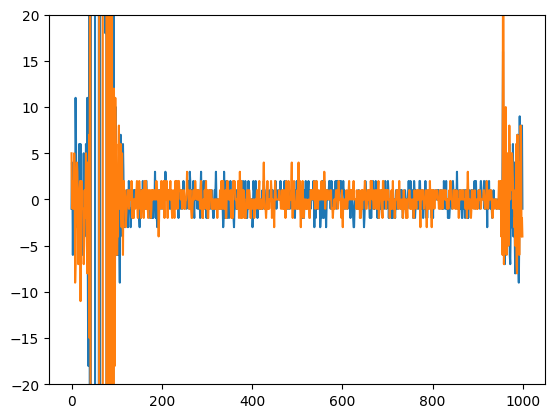

(200, 1000) (-2+0j) (-1.5026083-1.4964334j) dc offset -1,-1 noise std 0.71


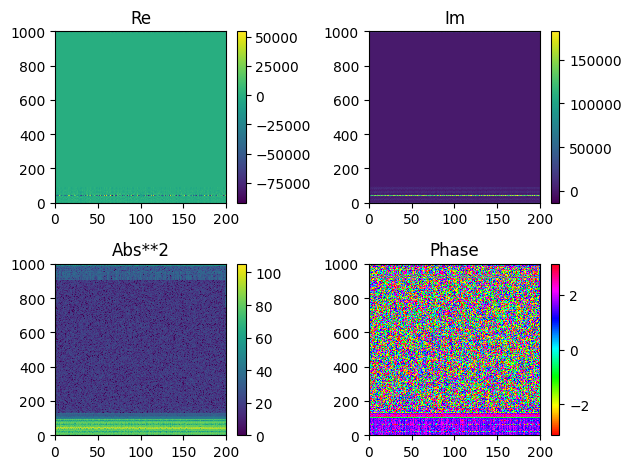

/e3d/data/2024/May/29/115029036.bin
WBeam idx 0 (200, 1000)


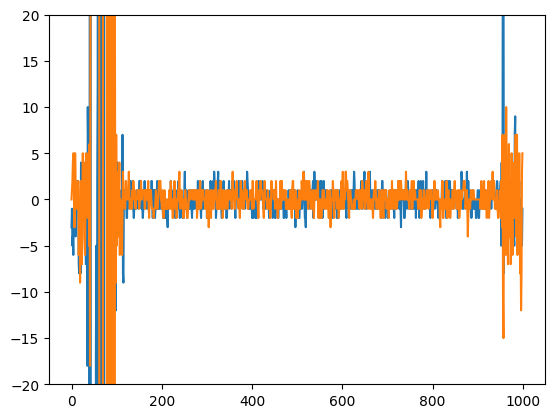

(200, 1000) (-2+0j) (-1.4999334-1.4953916j) dc offset -1,-1 noise std 0.71


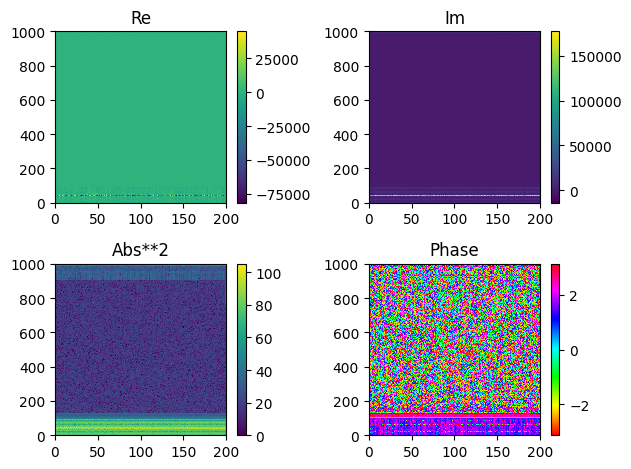

/e3d/data/2024/May/29/115029056.bin
WBeam idx 0 (200, 1000)


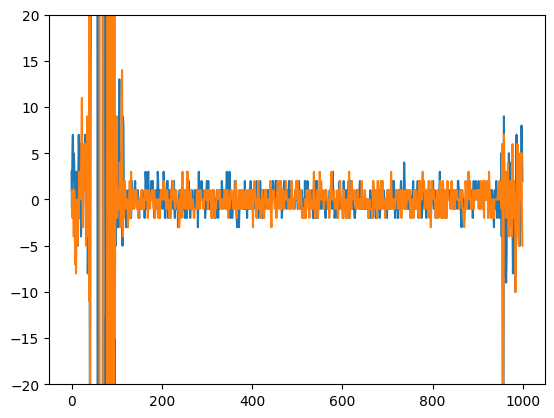

(200, 1000) (-2+0j) (-1.50095-1.4989417j) dc offset -1,-1 noise std 0.71


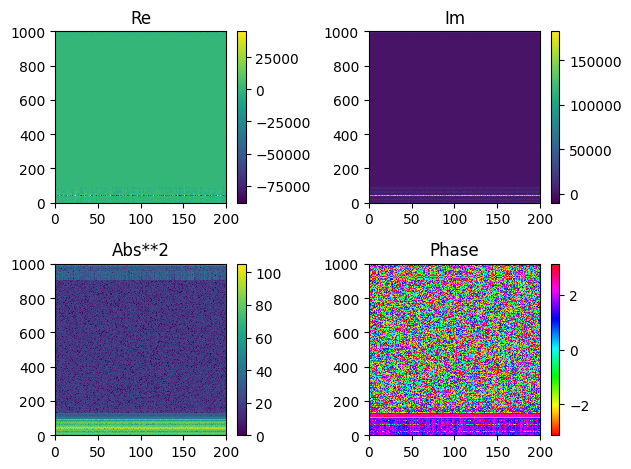

/e3d/data/2024/May/29/115029077.bin
WBeam idx 0 (200, 1000)


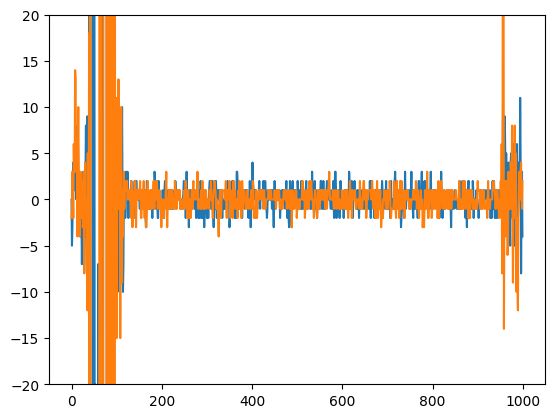

(200, 1000) (-2+1j) (-1.498225-1.5013417j) dc offset -1,-1 noise std 0.71


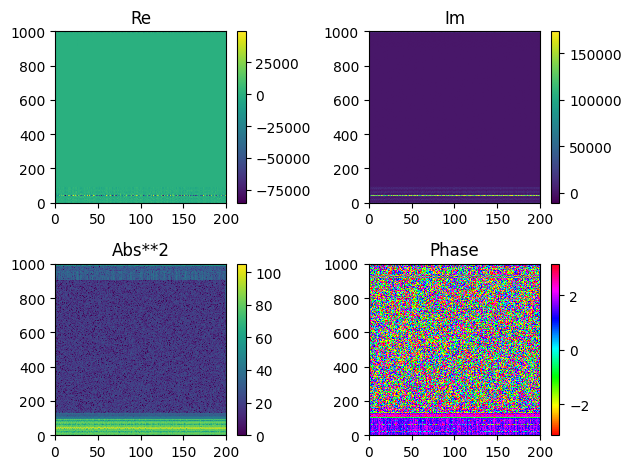

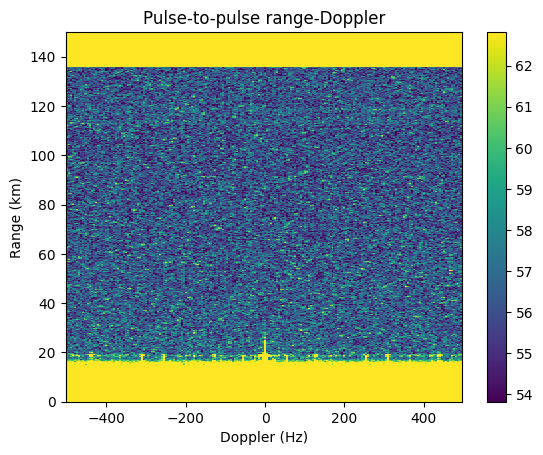

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from e3d.ext.par import dB
import numpy as n
import scipy.constants as c

S = n.zeros((n_pulses,ipp),dtype=n.float32)
Z=n.zeros((n_pulses,ipp),dtype=n.complex64)
sr=decimation.sample_clock_MHz
range_gates_km=n.arange(ipp)*0.15
doppler=n.fft.fftshift(n.fft.fftfreq(n_pulses,d=ipp/1e6))


code=n.array([+1, +1, +1, +1, +1, -1, -1, +1, +1, -1, +1, -1, +1],dtype=n.complex64)
code4=n.repeat(code,4)
CODE=n.conj(n.fft.fft(code4,ipp))

    #fig, ax = plt.subplots(figsize=(30, 10))
Z_prev=Z
for prod in op.wait(timeout=timedelta(seconds=60)):
    if prod:
        print(prod.path)
        if prod.metadata["type"] == "passthrough":
            print("WBeam idx", prod.metadata["ib"], end=" ")
            Z=prod.data
            Z.shape=(n_pulses,ipp)

            ZD=Z-Z_prev
            Z_prev=n.copy(Z)
            print(Z.shape)
            plt.plot(ZD[0,:].real)
            plt.plot(ZD[0,:].imag)
            plt.ylim([-20,20])
            plt.show()

            print(Z.shape, end=" ")
            Z.shape=(n_pulses,ipp)
            print(n.median(Z), end=" ")
            dc_offset=n.nanmean(Z[:,200:800])
            print(dc_offset, end=" ")
            Z=n.array(Z,dtype=n.complex64)
            Z=Z-dc_offset
            std_est=n.nanmedian(n.abs(Z))
            print("dc offset %d,%d noise std %1.2f"%(n.real(dc_offset),
                                                     n.imag(dc_offset),
                                                     std_est))
            
            #Z=Z-dc_offset
            if decode_barker:
                for ti in range(n_pulses):
                    Z[ti,:]=n.fft.ifft(n.fft.fft(Z[ti,:])*CODE)
                
            for ri in range(ipp):
                S[:,ri]+=n.abs(n.fft.fftshift(n.fft.fft(Z[:,ri])))**2.0


            plt.subplot(221)
            plt.pcolormesh(Z[:,0:1000].real.T)
            plt.title("Re")
            plt.colorbar()
            plt.subplot(222)
            plt.pcolormesh(Z[:,0:1000].imag.T)
            plt.title("Im")
            plt.colorbar()
            plt.subplot(223)
            plt.pcolormesh(10.0*n.log10(n.abs(Z[:,0:1000].T)**2.0),vmin=0)
            plt.title("Abs**2")
            plt.colorbar()
            plt.subplot(224)
            plt.pcolormesh(n.angle(Z[:,0:1000].T),cmap="hsv")
            plt.title("Phase")
            plt.colorbar()
            plt.tight_layout()
            plt.show()


    else:
        print(prod.label)

# plot the averaged range-Doppler power in dB

dB=10.0*n.log10(S.T)
noise_floor=n.nanmedian(dB)
plt.pcolormesh(doppler,range_gates_km,dB,vmin=noise_floor-3,vmax=noise_floor+6)
plt.ylim([0,150])
plt.ylabel("Range (km)")
plt.xlabel("Doppler (Hz)")
plt.title("Pulse-to-pulse range-Doppler")
plt.colorbar()
plt.show()

